# Machine Learning Project Checklist

1. Frame the problem and look at the big picture.

2. Get the data.

3. Explore the data to gain insights.

4. **Explore many different models and short-list the best ones.**

5. Fine-tune your models and combine them into a great solution.

6. Present your solution.

## 1. Frame the problem and look at the big picture

### Objective

Build an **intuitive** Machine Learning model to evaluate fair offer price of the given property in Budapest
- Dependent variable (predicted): **Price per squaremeter**
- Explanatory variables (features): GPS coordinates (**Latitude**, **Longitude**)

In [1]:
import os

In [2]:
REPO_DIR = os.path.join(os.environ['USERPROFILE'], 'repos')
PROJ_DIR = os.path.join(REPO_DIR, 'real_estate_machine_learning')
os.chdir(PROJ_DIR)

In [3]:
DATA_DIR = './data'
RPT_DIR = './reports'
MODEL_DIR = './model'
EXT_DIR = os.path.join(DATA_DIR, 'ext')
PRO_DIR = os.path.join(DATA_DIR, 'processed')
IMG_DIR = os.path.join(DATA_DIR, 'img')

In [4]:
import pandas as pd, numpy as np
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.pipeline import Pipeline
import datetime
import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode(connected=True)
%matplotlib inline

In [5]:
import src.preparation as prep
import src.processing as proc
from src.processing import extract_num
import src.visualization as viz
from src.utils import *

### Loading training and testing dataset for Regression
- Cleaned dataset
- Ready for fitting models

In [6]:
features = ['price_in_huf', 'area_size', 'price_per_sqm', 'lat', 'lng', 'address', 'city_district']

In [7]:
train_sale = pd.read_csv(os.path.join(PRO_DIR, 'training_sale_20181101.csv'), encoding='utf8')[features]
test_sale = pd.read_csv(os.path.join(PRO_DIR, 'testing_sale_20181101.csv'), encoding='utf8')[features]

In [8]:
min_gps=train_sale.min()
max_gps=train_sale.max()
pic_ratio=(max_gps['lat']-min_gps['lat'])/(max_gps['lng']-min_gps['lng'])

In [9]:
opt_fig_size = viz.calc_fig_size(pic_ratio, 2.5)

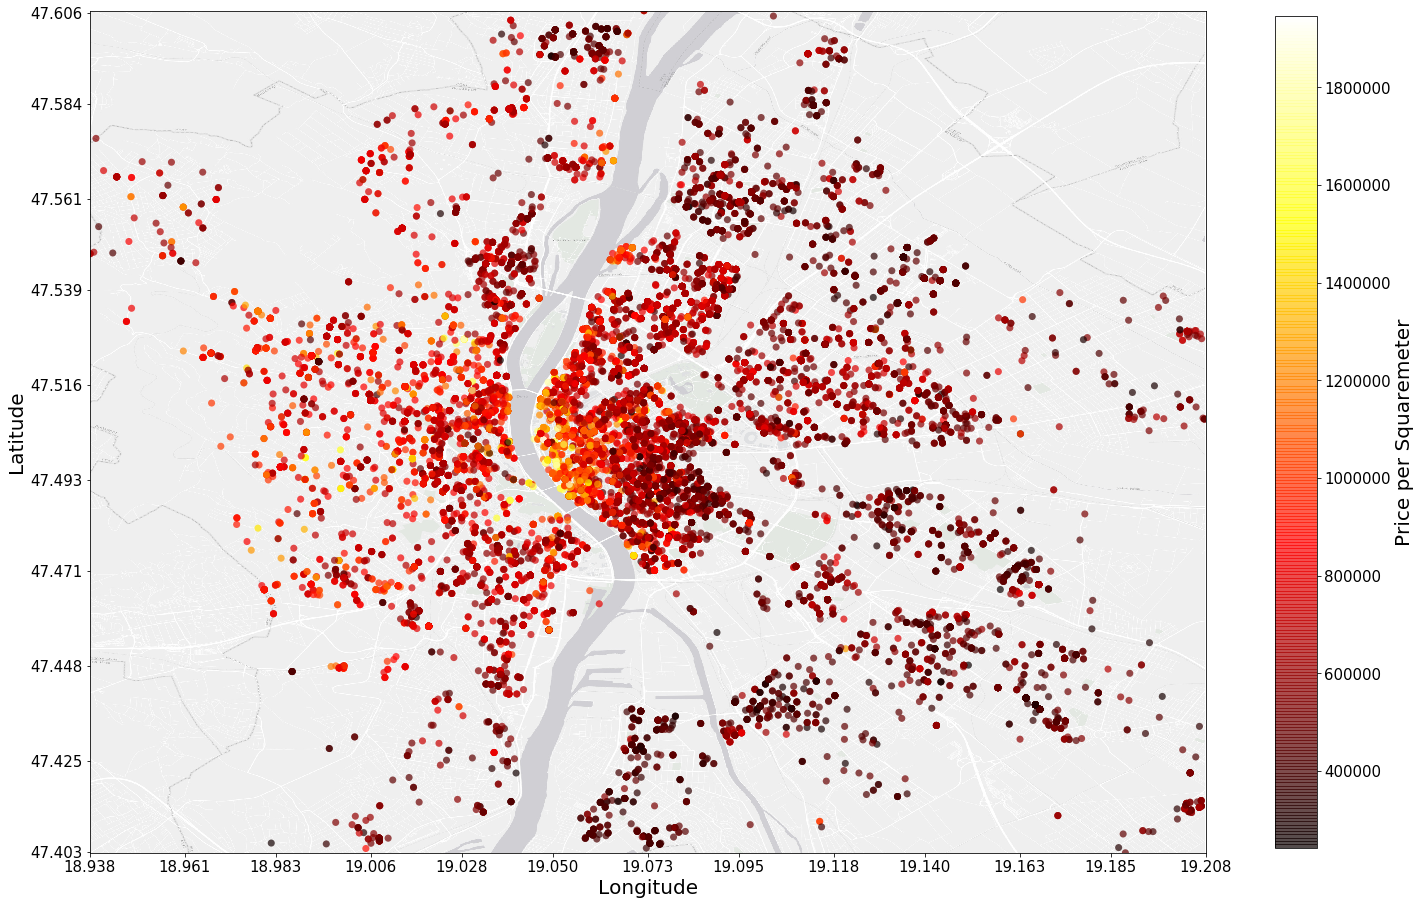

In [10]:
viz.plot_scatter_map(x=train_sale['lng'],
                 y=train_sale['lat'],
                 c=train_sale['price_per_sqm'],
                 colormap='hot', c_bar_shrink=0.81,
                 xlabel='Longitude', ylabel='Latitude', clabel='Price per Squaremeter',
                 linewidth=0, s=50, alpha=0.7,
                 figsize=opt_fig_size, dpi=160)
plt.show()

Dynamic plotly graph: 

In [12]:
t = viz.create_scatter_text(lat=train_sale.lat.values,
                 lat_text='Latitude',
                 lng=train_sale.lng.values,
                 lng_text='Longitude',
                 addr0=train_sale.city_district.values,
                 addr1=train_sale.address.values,
                 addr_text='District',
                 pps=train_sale.price_per_sqm.values,
                 pps_text='Price per sqm',
                 price=train_sale.price_in_huf,
                 price_text='Price',
                 area=train_sale.area_size,
                 area_text='Area size')

In [13]:
center_gps = {'lat':min_gps['lat']+(max_gps['lat']-min_gps['lat'])/2,
          'lng':min_gps['lng']+(max_gps['lng']-min_gps['lng'])/2}

In [ ]:
viz.generate_plotly_scattermapbox(train_sale.lng, train_sale.lat, train_sale.price_per_sqm, center_lat=center_gps['lat'], center_lng=center_gps['lng'], cbar_title='Price<br>per sqm', marker_size=8, text=t, save_to_path=os.path.join(RPT_DIR, 'scatter_map_box.html'), show=False, publish_name='scatter_map_box')

## Experiment with different algorithms:
- Fitting different models
- Define X variables and y dependent variable

In [15]:
X_train_sale, y_train_sale = train_sale[['lat', 'lng']], train_sale['price_per_sqm']

Define some evaluation functions:

In [16]:
def print_cross_validation(estimator, X, y, cv=10):
    score = cross_val_score(cv=cv, estimator=estimator, X=X, y=y)
    n_folds = len(score)
    r2_mean_valid, r2_std_valid = score.mean(), score.std()
    print('Mean R2 on {number_of} validation folds: {mean:.3%} with {std:.3%} standard deviation.'.format(number_of=n_folds, mean=r2_mean_valid, std=r2_std_valid))
    return r2_mean_valid

In [17]:
def print_gs_cross_validation(grid_search):
    n_folds = grid_search.cv
    r2_mean_train, r2_std_train = grid_search.cv_results_['mean_train_score'][grid_search.best_index_], grid_search.cv_results_['std_train_score'][grid_search.best_index_]
    r2_mean_valid, r2_std_valid = grid_search.cv_results_['mean_test_score'][grid_search.best_index_], grid_search.cv_results_['std_test_score'][grid_search.best_index_]
    print('Mean R2 on {number_of} training folds: {mean:.3%} with {std:.3%} standard deviation.'.format(number_of=n_folds, mean=r2_mean_train, std=r2_std_train))
    print('Mean R2 on {number_of} validation folds: {mean:.3%} with {std:.3%} standard deviation.'.format(number_of=n_folds, mean=r2_mean_valid, std=r2_std_valid))
    return r2_mean_valid

### Linear regression:

In [18]:
lin_reg = linear_model.LinearRegression(fit_intercept=True)

In [19]:
lin_reg.fit(X=X_train_sale, y=y_train_sale)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [20]:
r2_mean_valid = print_cross_validation(lin_reg, X_train_sale, y_train_sale)

Mean R2 on 10 validation folds: 15.232% with 4.161% standard deviation.


Calculate grid for plotting:

In [21]:
X, Y, Z = viz.create_grid(data_points=200, model=lin_reg, x_first_feature=False,
            x_max=max_gps['lng'], x_min=min_gps['lng'], y_max=max_gps['lat'], y_min=min_gps['lat'])

In [22]:
xyz_label = {'x_label':'Longitude', 'y_label':'Latitude', 'z_label':'Price per sqm'}

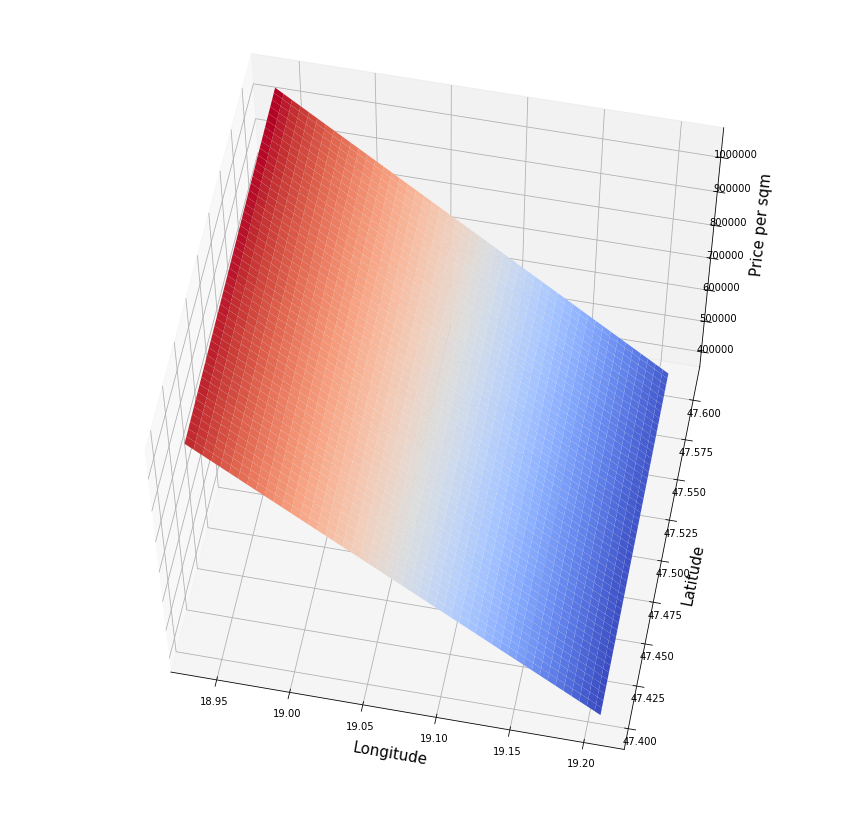

In [24]:
model_name='lin_model_{0:.0f}'.format(r2_mean_valid*100)
viz.plot_3d_surface(X=X, Y=Y, Z=Z, **xyz_label, label_fs=15,  figsize=(15,15), elevation=60, rotation=-79, saving=True, dir_name=IMG_DIR, model_name=model_name)
plt.show()

### Polynomial regression:
#### Hyperparameter:
- Degree of polynomial function

In [23]:
gs_poly=load_pkl(os.path.join(MODEL_DIR, 'poly_model_26.pkl'))

In [26]:
poly_reg = Pipeline([
        ('poly_features', PolynomialFeatures(include_bias=True)),
        ('lin_reg', linear_model.LinearRegression()),
    ])

In [38]:
gs_poly = GridSearchCV(estimator=poly_reg, param_grid={'poly_features__degree':[*range(1, 21, 2)]}, cv=10, return_train_score=True)

Fitting training data:

In [39]:
gs_poly.fit(X=X_train_sale, y=y_train_sale)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('poly_features', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('lin_reg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'poly_features__degree': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Evaluate results:

In [40]:
gs_poly.grid_scores_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning:

The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20



[mean: 0.15232, std: 0.04161, params: {'poly_features__degree': 1},
 mean: 0.25699, std: 0.04090, params: {'poly_features__degree': 3},
 mean: 0.27212, std: 0.04016, params: {'poly_features__degree': 5},
 mean: 0.27076, std: 0.04077, params: {'poly_features__degree': 7},
 mean: 0.27295, std: 0.03640, params: {'poly_features__degree': 9},
 mean: 0.27237, std: 0.03919, params: {'poly_features__degree': 11},
 mean: 0.27244, std: 0.03943, params: {'poly_features__degree': 13},
 mean: 0.27250, std: 0.03903, params: {'poly_features__degree': 15},
 mean: 0.27176, std: 0.04013, params: {'poly_features__degree': 17},
 mean: 0.27248, std: 0.03918, params: {'poly_features__degree': 19}]

In [41]:
gs_poly.cv_results_

{'mean_fit_time': array([0.03230181, 0.08860505, 0.11680672, 0.30281725, 0.48592775,
        0.84954863, 1.29447396, 2.56984694, 6.35806363, 6.54917459]),
 'mean_score_time': array([0.00260015, 0.00370018, 0.0067003 , 0.01000054, 0.01540089,
        0.02530143, 0.05910349, 0.04850278, 0.1755101 , 0.17501009]),
 'mean_test_score': array([0.152319  , 0.25699145, 0.27212033, 0.27075821, 0.27295311,
        0.27236706, 0.27244117, 0.27249986, 0.2717607 , 0.27247561]),
 'mean_train_score': array([0.16065444, 0.2653793 , 0.28089747, 0.28085678, 0.28011212,
        0.28138709, 0.28157437, 0.28130292, 0.27989093, 0.28146518]),
 'param_poly_features__degree': masked_array(data=[1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'poly_features__degree': 1},
  {'poly_features__degree': 3},
  {'poly_features__degree': 5},
  {'poly_features

In [42]:
gs_poly.best_params_

{'poly_features__degree': 9}

#### The best model:

In [43]:
r2_mean_valid = print_gs_cross_validation(gs_poly)

Mean R2 on 10 training folds: 28.011% with 0.268% standard deviation.
Mean R2 on 10 validation folds: 27.295% with 3.640% standard deviation.


Calculate grid for plotting:

In [44]:
X, Y, Z = viz.create_grid(data_points=200, model=gs_poly, x_first_feature=False,
            x_max=max_gps['lng'], x_min=min_gps['lng'], y_max=max_gps['lat'], y_min=min_gps['lat'])

Vizualize the decision function in 3D:

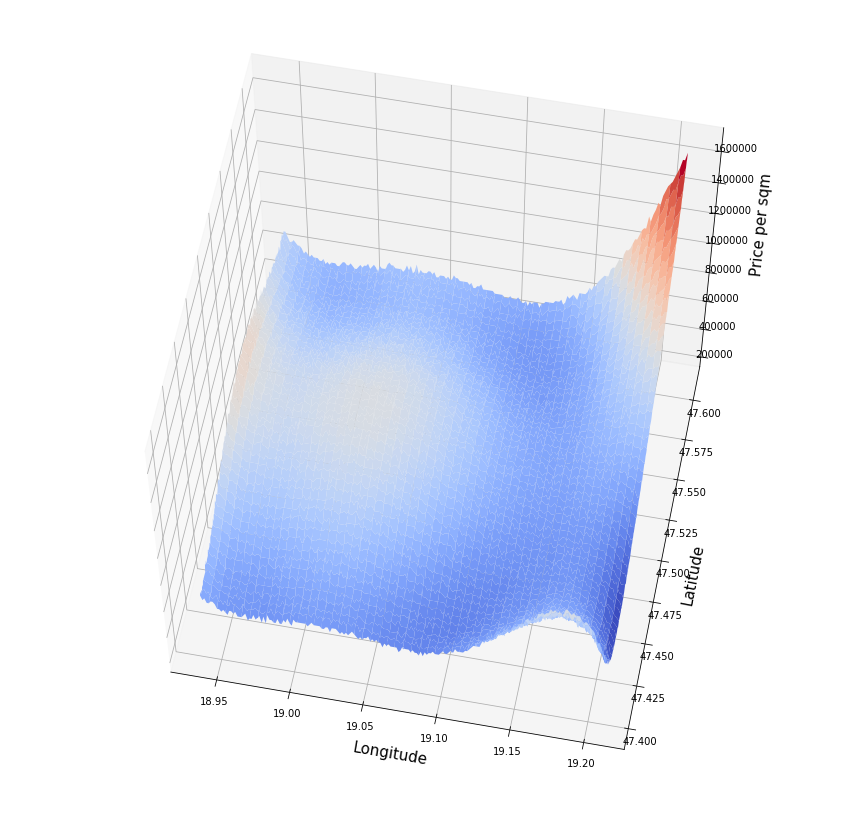

In [45]:
model_name='poly_model_{0:.0f}'.format(r2_mean_valid*100)
viz.plot_3d_surface(X=X, Y=Y, Z=Z, **xyz_label, label_fs=15, figsize=(15,15), elevation=60, rotation=-79, saving=True, dir_name=IMG_DIR, model_name=model_name)
plt.show()

In [46]:
T=viz.create_surface_text(X, Y, Z, *xyz_label.values())

In [47]:
def create_surface_text(x, y, z, x_text, y_text, z_text):
    return '{x_text}: {x:.4f}<br>{y_text}: {y:.4f}<br>{z_text}: {z:.2f}k'.format(x=x, y=y, z=z/1000, x_text=x_text, y_text=y_text, z_text=z_text)
create_surface_text = np.vectorize(create_surface_text)

In [48]:
viz.generate_plotly_surface(X, Y, Z, T=T, **xyz_label, title='For-sale in Budapest', cbar_title='Price <br>per sqm',
                        save_to_path=os.path.join(RPT_DIR, model_name +'.html'), show=False, publish_name='poly_model_26')

Save the model:

In [50]:
save_pkl(obj=gs_poly, pkl_path=os.path.join(MODEL_DIR, model_name+'.pkl'))

'./model\\poly_model_27.pkl'

---

### SVM Regression:
#### Hyperparameters:
Kernel: Gaussian Radial Basis function
- *C* as regularization/smoothing parameter
- *Gamma* defines kurtosis of the Gaussian curve  

Tuning hyperparamters with GridSearch, explanatory variables, should be standardized to help the algorithm to converge.

In [33]:
gs_svr = load_pkl(os.path.join(MODEL_DIR, 'svr_model_48.pkl'))

In [51]:
svm_reg = Pipeline([
        ('scaler', StandardScaler()),
        ('svr', SVR(kernel='rbf', C=100000, gamma=100)),
    ])

In [ ]:
gs_svr = GridSearchCV(cv=10,
                      estimator=svm_reg,
                      return_train_score=True,
                      param_grid={'svr__C': [1000, 10000, 50000, 100000], 'svr__gamma': [1, 10, 100, 1000, 10000]})

Fitting the training data

In [52]:
svm_reg.fit(X=X_train_sale, y=y_train_sale)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svr', SVR(C=100000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=100,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])

In [81]:
gs_svr.fit(X=X_train_sale, y=y_train_sale)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svr', SVR(C=210000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1000,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'svr__C': [1000, 10000, 50000, 100000], 'svr__gamma': [1, 10, 100, 1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Evaluation of hyperparamters tuning: 

In [34]:
gs_svr.best_params_

{'svr__C': 100000, 'svr__gamma': 100}

In [53]:
r2_mean_valid = print_cross_validation(cv=10, estimator=svm_reg, X=X_train_sale, y=y_train_sale)

Mean R2 on 10 validation folds: 49.526% with 4.826% standard deviation.


In [48]:
r2_mean_valid = print_gs_cross_validation(gs_svr)

Mean R2 on 10 training folds: 54.814% with 0.425% standard deviation.
Mean R2 on 10 validation folds: 48.126% with 4.535% standard deviation.


Calculating grid for plotting:

In [55]:
X, Y, Z = viz.create_grid(data_points=200, model=svm_reg, x_first_feature=False,
            x_max=max_gps['lng'], x_min=min_gps['lng'], y_max=max_gps['lat'], y_min=min_gps['lat'])

Vizualize the decision function in 3D:

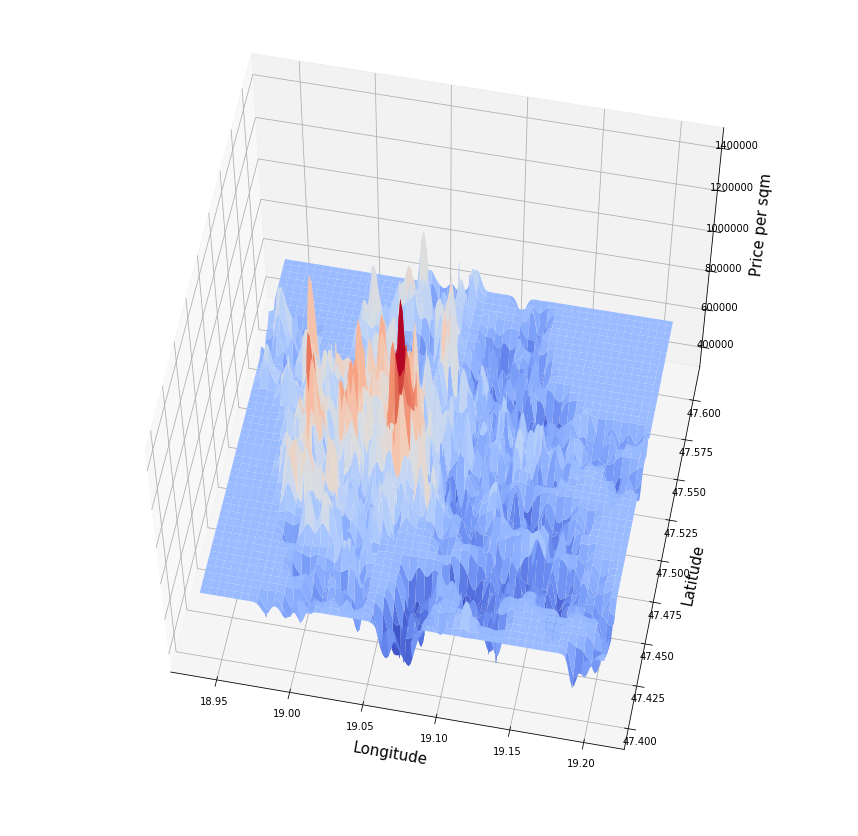

In [56]:
model_name='svr_model_{0:.0f}'.format(r2_mean_valid*100)
viz.plot_3d_surface(X=X, Y=Y, Z=Z, **xyz_label, figsize=(15,15), elevation=60, rotation=-79, saving=True, dir_name=IMG_DIR, model_name=model_name)
plt.show()

Create a rotatable 3D surface in plotly:

In [57]:
T=viz.create_surface_text(X, Y, Z, *xyz_label.values())

In [58]:
viz.generate_plotly_surface(X, Y, Z, T=T, **xyz_label, title='For-sale in Budapest', cbar_title='Price <br>per sqm',
                        save_to_path=os.path.join(RPT_DIR, model_name + '.html'), show=False, publish_name='svr_model_48')

Save the best model:

In [60]:
save_pkl(obj=svm_reg, pkl_path=os.path.join(MODEL_DIR, model_name+'.pkl'))

'./model\\svr_model_50.pkl'

---

As a result of the hyperparameter tuning the best model is one of the most unregularized model, it is worth having a look on more regularized model as well, which still performs relatively well.
- *C* = 10000
- *gamma* = 10

In [41]:
svm_reg = load_pkl(os.path.join(MODEL_DIR, 'svr_model_43.pkl'))

In [61]:
svm_reg = Pipeline([
        ('scaler', StandardScaler()),
        ('svr', SVR(kernel='rbf', C=10000, gamma=10)),
    ])

Fitting the training data

In [62]:
svm_reg.fit(X=X_train_sale, y=y_train_sale)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svr', SVR(C=10000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=10,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])

In [63]:
r2_mean_valid = print_cross_validation(estimator=svm_reg, X=X_train_sale, y=y_train_sale)

Mean R2 on 10 validation folds: 44.372% with 4.201% standard deviation.


Calculate grid for plotting:

In [64]:
X, Y, Z = viz.create_grid(data_points=200, model=svm_reg, x_first_feature=False,
            x_max=max_gps['lng'], x_min=min_gps['lng'], y_max=max_gps['lat'], y_min=min_gps['lat'])

Vizualize the decision function in 3D:

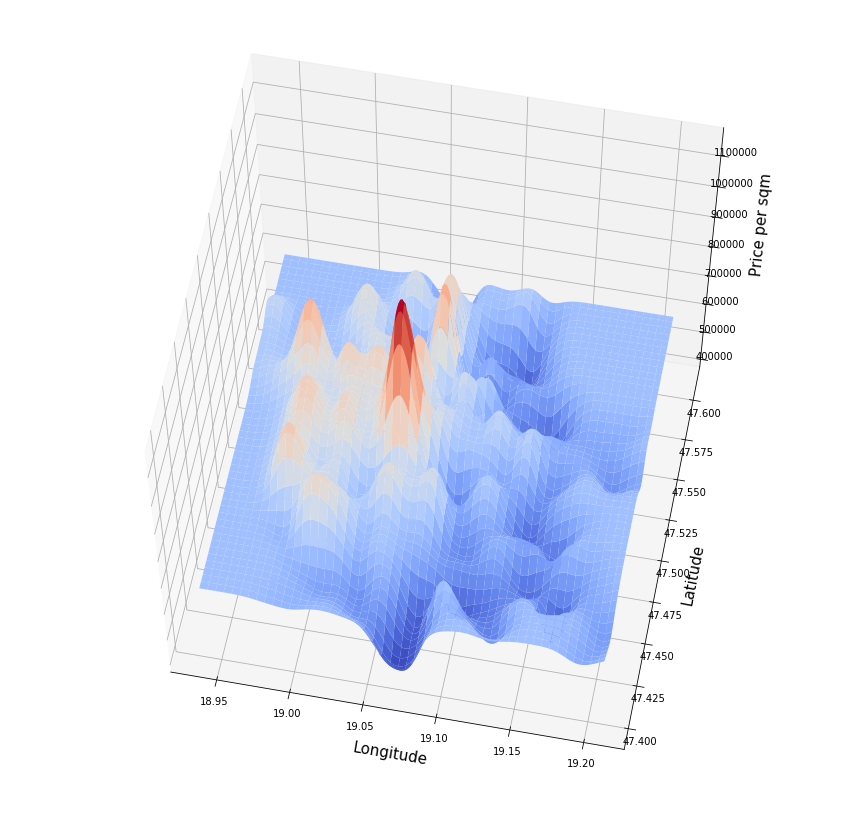

In [65]:
model_name='svr_model_{0:.0f}'.format(r2_mean_valid*100)
viz.plot_3d_surface(X=X, Y=Y, Z=Z, **xyz_label, figsize=(15,15), elevation=60, rotation=-79, saving=True, dir_name=IMG_DIR, model_name=model_name)
plt.show()

Create a rotatable 3D surface in plotly:

In [66]:
T=viz.create_surface_text(X, Y, Z, *xyz_label.values())

In [67]:
viz.generate_plotly_surface(X, Y, Z, T=T, **xyz_label, title='For-sale in Budapest', cbar_title='Price <br>per sqm',
                        save_to_path=os.path.join(RPT_DIR, model_name + '.html'), show=False, publish_name='svr_model_43')

Save the model:

In [68]:
save_pkl(obj=svm_reg, pkl_path=os.path.join(MODEL_DIR, model_name+'.pkl'))

'./model\\svr_model_44.pkl'

---

### Decision Tree Regression:

Decision Tree Hyperparameters:
- max_depth
- min_samples_split
- min_samples_leaf (leaf_node: pure node, where gini/entrophy = 0)
- min_weight_fraction
- max_features
- max_leaf_nodes
- min_impurity_decrease
- min_impurity_split

In [69]:
gs_tree = load_pkl(os.path.join(MODEL_DIR, 'tree_model_50.pkl'))

In [71]:
tree_reg = DecisionTreeRegressor(min_samples_leaf = 10, min_samples_split = 10, max_depth=100)

In [72]:
gs_tree = GridSearchCV(estimator=tree_reg, cv=10, param_grid={'max_depth': list(np.arange(1,10)*10), 'max_leaf_nodes': list(10*np.arange(10, 31))}, return_train_score=True, n_jobs=-1)

In [73]:
gs_tree.fit(X=X_train_sale, y=y_train_sale)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=100, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=10,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90], 'max_leaf_nodes': [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Evaluation of hyperparamters tuning: 

In [74]:
gs_tree.best_params_

{'max_depth': 90, 'max_leaf_nodes': 300}

In [75]:
gs_tree.best_score_

0.5112468487308288

In [76]:
gs_tree.cv_results_

{'mean_fit_time': array([0.04836009, 0.05928013, 0.04836011, 0.05148013, 0.04836011,
        0.05148008, 0.0624001 , 0.0514801 , 0.04836009, 0.05148015,
        0.06396008, 0.05616007, 0.05616014, 0.05460007, 0.05772009,
        0.06708009, 0.0530401 , 0.06084003, 0.0530401 , 0.05148005,
        0.05928006, 0.04680007, 0.04836013, 0.0530401 , 0.05772004,
        0.0514801 , 0.05148015, 0.05460014, 0.05772011, 0.05460014,
        0.05616012, 0.05772011, 0.05304008, 0.05772014, 0.05460019,
        0.05148003, 0.0530401 , 0.05772011, 0.05928009, 0.05772011,
        0.05616014, 0.05928013, 0.04679999, 0.04992013, 0.04992015,
        0.05148005, 0.05460012, 0.0530401 , 0.04992015, 0.04836006,
        0.05928009, 0.0530401 , 0.05148013, 0.05772011, 0.05772009,
        0.05928011, 0.05148017, 0.05772014, 0.05304008, 0.0655201 ,
        0.05304005, 0.05616004, 0.05772009, 0.05460007, 0.05148008,
        0.04368007, 0.04992013, 0.04992013, 0.06240015, 0.04836006,
        0.0546001 , 0.05304017,

In [77]:
r2_mean_valid = print_gs_cross_validation(grid_search=gs_tree)

Mean R2 on 10 training folds: 60.401% with 0.402% standard deviation.
Mean R2 on 10 validation folds: 51.125% with 4.843% standard deviation.


In [78]:
gs_tree.best_estimator_.feature_importances_

array([0.36218244, 0.63781756])

Calculate a grid:

In [79]:
X, Y, Z = viz.create_grid(data_points=200, model=gs_tree, x_first_feature=False,
            x_max=max_gps['lng'], x_min=min_gps['lng'], y_max=max_gps['lat'], y_min=min_gps['lat'])

Vizualize the decision function in 3D:

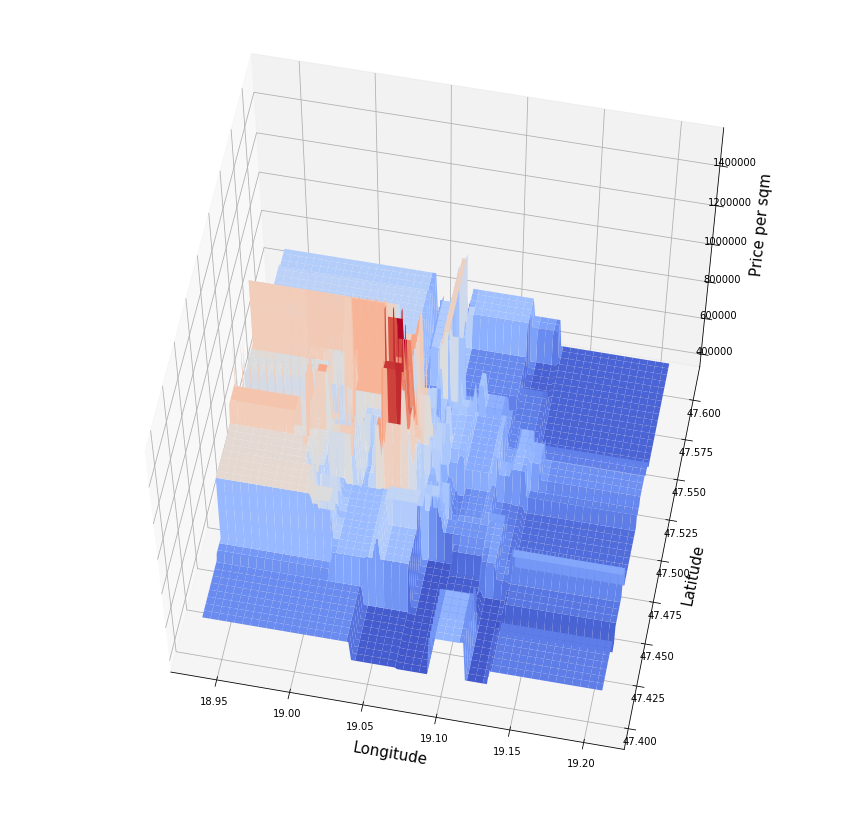

In [80]:
model_name='tree_model_{0:.0f}'.format(r2_mean_valid*100)
viz.plot_3d_surface(X=X, Y=Y, Z=Z, **xyz_label, figsize=(15,15), elevation=60, rotation=-79, saving=True, dir_name=IMG_DIR, model_name=model_name)
plt.show()

Create a rotatable 3D surface in plotly:

In [81]:
T=viz.create_surface_text(X, Y, Z, *xyz_label.values())

In [82]:
viz.generate_plotly_surface(X, Y, Z, T=T, **xyz_label, title='For-sale in Budapest', cbar_title='Price <br>per sqm',
                        save_to_path=os.path.join(RPT_DIR, model_name + '.html'), show=False, publish_name='tree_model_50')

Save the best model:

In [83]:
save_pkl(obj=gs_tree, pkl_path=os.path.join(MODEL_DIR, model_name + '.pkl'))

'./model\\tree_model_51.pkl'

### Random Forest Regression:
Training 100 Decison trees on random records of the training data

In [59]:
forest_reg = load_pkl(os.path.join(MODEL_DIR, 'forest_model_57.pkl'))

In [133]:
forest_reg = RandomForestRegressor(min_samples_leaf= 10, min_samples_split= 10, max_depth=60, max_leaf_nodes=300, bootstrap=True, oob_score=True, n_estimators=100, n_jobs=-1)

In [134]:
forest_reg.fit(X=X_train_sale, y=y_train_sale)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=60,
           max_features='auto', max_leaf_nodes=300,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [139]:
r2_mean_valid = forest_reg.oob_score_
print("Mean R2 on 'out of bag' data: {mean:.3%}.".format(mean=r2_mean_valid))

Mean R2 on 'out of bag' data: 57.928%.


In [140]:
X, Y, Z = viz.create_grid(data_points=200, model=forest_reg, x_first_feature=False,
            x_max=max_gps['lng'], x_min=min_gps['lng'], y_max=max_gps['lat'], y_min=min_gps['lat'])

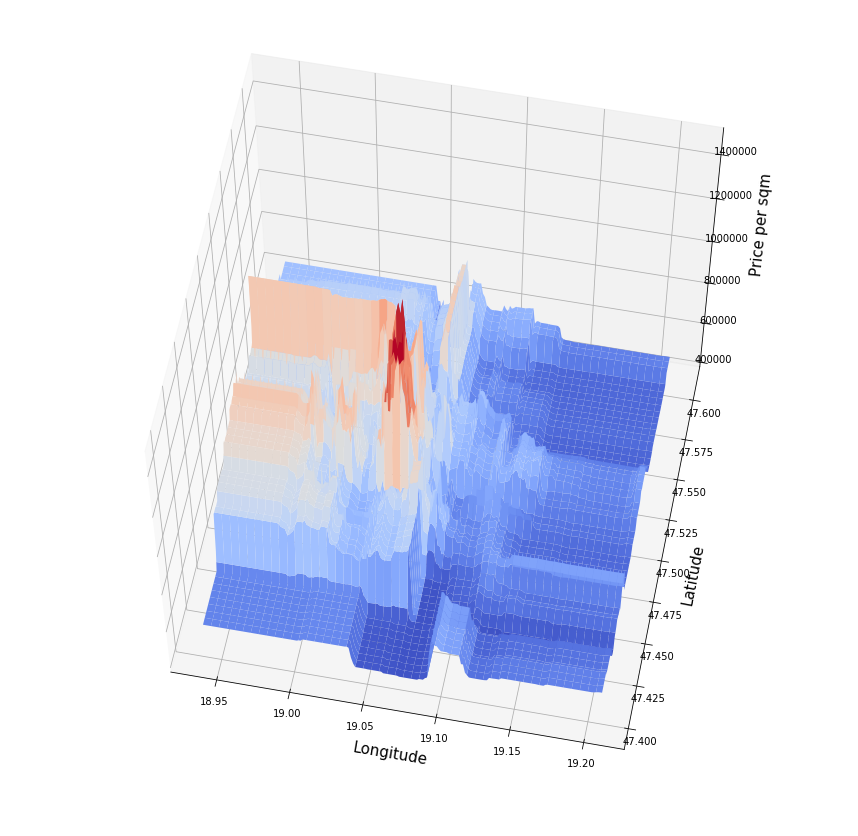

In [141]:
model_name='forest_model_{0:.0f}'.format(r2_mean_valid*100)
viz.plot_3d_surface(X=X, Y=Y, Z=Z, **xyz_label, figsize=(15,15), elevation=60, rotation=-79, saving=True, dir_name=IMG_DIR, model_name=model_name)
plt.show()

Create a rotatable 3D surface in plotly:

In [142]:
T=viz.create_surface_text(X, Y, Z, *xyz_label.values())

In [143]:
viz.generate_plotly_surface(X, Y, Z, T=T, **xyz_label, title='For-sale in Budapest', cbar_title='Price <br>per sqm',
                        save_to_path=os.path.join(RPT_DIR, model_name + '.html'), show=False)#, publish_name='forest_model_57')

Save the model:

In [145]:
save_pkl(obj=forest_reg, pkl_path=os.path.join(MODEL_DIR, model_name+'.pkl'))

'./model\\forest_model_58.pkl'

### Boosting Regression:
- Adaptive Boosting
- Gradient Boosting  

The idea is the same to train a lot of weak learners to generate ensemble model. Weak learner can be any well regularized model such as SVM, Decision tree. In this case I chose decision tree, since it can be trained pretty fast as opposed to SVM.

#### AdaBoost:

In [65]:
ada_reg = load_pkl(os.path.join(MODEL_DIR, 'ada_model_49.pkl'))

In [37]:
ada_reg.n_estimators

10000

In [93]:
tree_reg = DecisionTreeRegressor(max_depth=10)

In [94]:
ada_reg = AdaBoostRegressor(base_estimator=tree_reg, n_estimators=10000)

In [95]:
ada_reg.fit(X=X_train_sale, y=y_train_sale)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=10000,
         random_state=None)

In [96]:
r2_mean_valid = print_cross_validation(cv=10, estimator=ada_reg, X=X_train_sale, y=y_train_sale)

Mean R2 on 10 validation folds: 47.378% with 4.403% standard deviation.


In [98]:
X, Y, Z = viz.create_grid(data_points=200, model=ada_reg, x_first_feature=False,
            x_max=max_gps['lng'], x_min=min_gps['lng'], y_max=max_gps['lat'], y_min=min_gps['lat'])

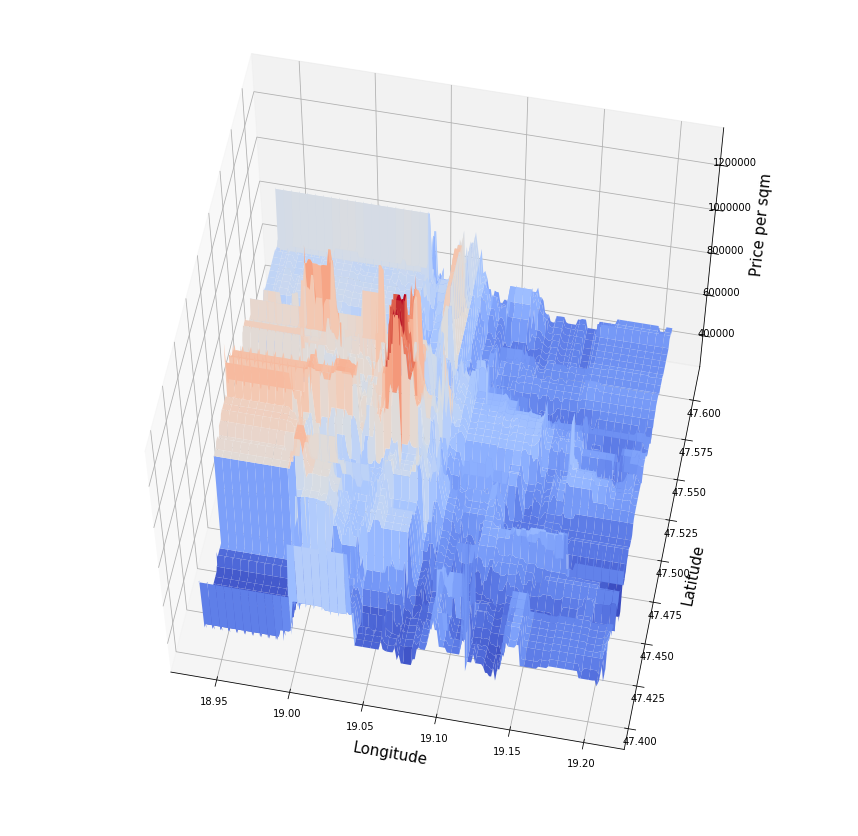

In [99]:
model_name='ada_model_{0:.0f}'.format(r2_mean_valid*100)
viz.plot_3d_surface(X=X, Y=Y, Z=Z, **xyz_label, figsize=(15,15), elevation=60, rotation=-79, saving=True, dir_name=IMG_DIR, model_name=model_name)
plt.show()

Create a rotatable 3D surface in plotly:

In [100]:
T=viz.create_surface_text(X, Y, Z, *xyz_label.values())

In [101]:
viz.generate_plotly_surface(X, Y, Z, T=T, **xyz_label, title='For-sale in Budapest', cbar_title='Price <br>per sqm',
                        save_to_path=os.path.join(RPT_DIR, model_name + '.html'), show = False, publish_name='ada_model_49')

Save the model:

In [102]:
save_pkl(obj=ada_reg, pkl_path=os.path.join(MODEL_DIR, model_name +'.pkl'))

'./model\\ada_model_47.pkl'

#### GradBoost:

In [71]:
grad_reg = load_pkl(os.path.join(MODEL_DIR, 'grad_model_55.pkl'))

In [104]:
grad_reg = GradientBoostingRegressor(max_depth=10, n_estimators=100)

In [105]:
grad_reg.max_depth

10

In [109]:
grad_reg.fit(X=X_train_sale, y=y_train_sale)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=10, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [110]:
r2_mean_valid = print_cross_validation(cv=10, estimator=grad_reg, X=X_train_sale, y=y_train_sale)

Mean R2 on 10 validation folds: 55.999% with 4.791% standard deviation.


In [111]:
X, Y, Z = viz.create_grid(data_points=200, model=grad_reg, x_first_feature=False,
            x_max=max_gps['lng'], x_min=min_gps['lng'], y_max=max_gps['lat'], y_min=min_gps['lat'])

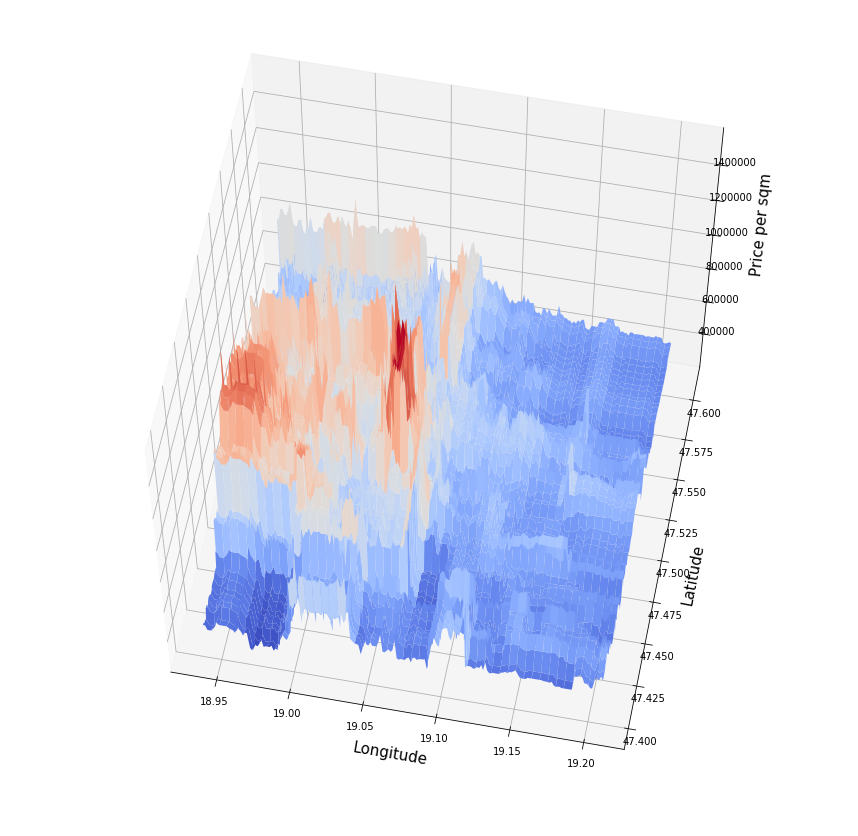

In [112]:
model_name='grad_model_{0:.0f}'.format(r2_mean_valid*100)
viz.plot_3d_surface(X=X, Y=Y, Z=Z, **xyz_label, figsize=(15,15), elevation=60, rotation=-79, saving=True, dir_name=IMG_DIR, model_name=model_name)
plt.show()

Create a rotatable 3D surface in plotly:

In [113]:
T=viz.create_surface_text(X, Y, Z, *xyz_label.values())

In [114]:
viz.generate_plotly_surface(X, Y, Z, T=T, **xyz_label, title='For-sale in Budapest', cbar_title='Price <br>per sqm',
                        save_to_path=os.path.join(RPT_DIR, model_name + '.html'), show = False, publish_name='grad_model_55')

In [115]:
save_pkl(obj=grad_reg, pkl_path=os.path.join(MODEL_DIR, model_name +'.pkl'))

'./model\\grad_model_56.pkl'

### K-Neighbors Regression:

In [77]:
gs_neigh = load_pkl(os.path.join(MODEL_DIR, 'neigh_model_54.pkl'))

In [55]:
gs_neigh.best_estimator_

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=88, p=2,
          weights='distance')

In [117]:
neigh_reg = KNeighborsRegressor(weights='distance', p=2, n_jobs=-1, n_neighbors=88)

In [118]:
gs_neigh = GridSearchCV(estimator=neigh_reg, param_grid={'n_neighbors':[16, 32, 64, 80, 84, 88, 92, 96, 112, 128, 256, 512], 'weights':['distance'], 'p':[2]}, n_jobs=-1, cv=10, return_train_score=True)

In [119]:
gs_neigh.fit(X=X_train_sale, y=y_train_sale)

GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=88, p=2,
          weights='distance'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': [16, 32, 64, 80, 84, 88, 92, 96, 112, 128, 256, 512], 'weights': ['distance'], 'p': [2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [120]:
gs_neigh.grid_scores_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning:

The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20



[mean: 0.54094, std: 0.05477, params: {'n_neighbors': 16, 'p': 2, 'weights': 'distance'},
 mean: 0.54654, std: 0.05164, params: {'n_neighbors': 32, 'p': 2, 'weights': 'distance'},
 mean: 0.54753, std: 0.05204, params: {'n_neighbors': 64, 'p': 2, 'weights': 'distance'},
 mean: 0.54779, std: 0.05233, params: {'n_neighbors': 80, 'p': 2, 'weights': 'distance'},
 mean: 0.54787, std: 0.05235, params: {'n_neighbors': 84, 'p': 2, 'weights': 'distance'},
 mean: 0.54784, std: 0.05240, params: {'n_neighbors': 88, 'p': 2, 'weights': 'distance'},
 mean: 0.54805, std: 0.05249, params: {'n_neighbors': 92, 'p': 2, 'weights': 'distance'},
 mean: 0.54801, std: 0.05253, params: {'n_neighbors': 96, 'p': 2, 'weights': 'distance'},
 mean: 0.54777, std: 0.05268, params: {'n_neighbors': 112, 'p': 2, 'weights': 'distance'},
 mean: 0.54763, std: 0.05268, params: {'n_neighbors': 128, 'p': 2, 'weights': 'distance'},
 mean: 0.54613, std: 0.05350, params: {'n_neighbors': 256, 'p': 2, 'weights': 'distance'},
 mean: 

In [121]:
gs_neigh.best_params_

{'n_neighbors': 92, 'p': 2, 'weights': 'distance'}

In [122]:
r2_mean_valid = print_gs_cross_validation(grid_search=gs_neigh)

Mean R2 on 10 training folds: 71.607% with 0.403% standard deviation.
Mean R2 on 10 validation folds: 54.805% with 5.249% standard deviation.


In [123]:
X, Y, Z = viz.create_grid(data_points=200, model=gs_neigh, x_first_feature=False,
            x_max=max_gps['lng'], x_min=min_gps['lng'], y_max=max_gps['lat'], y_min=min_gps['lat'])

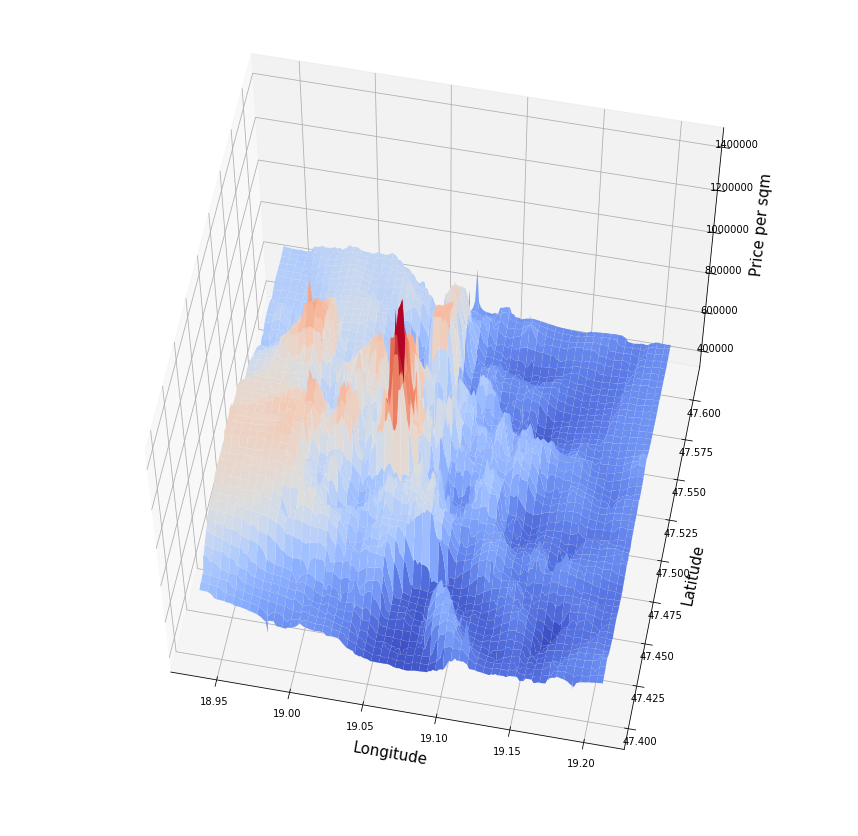

In [124]:
model_name='neigh_model_{0:.0f}'.format(r2_mean_valid*100)
viz.plot_3d_surface(X=X, Y=Y, Z=Z, **xyz_label, figsize=(15,15), elevation=60, rotation=-79, saving=True, dir_name=IMG_DIR, model_name=model_name)
plt.show()

Create a rotatable 3D surface in plotly:

In [125]:
T=viz.create_surface_text(X, Y, Z, *xyz_label.values())

In [126]:
viz.generate_plotly_surface(X, Y, Z, T=T, **xyz_label, title='For-sale in Budapest', cbar_title='Price <br>per sqm',
                        save_to_path=os.path.join(RPT_DIR, model_name + '.html'), show = False, publish_name='neigh_model_54')

In [127]:
save_pkl(obj=grad_reg, pkl_path=os.path.join(MODEL_DIR, model_name +'.pkl'))

'./model\\neigh_model_55.pkl'

### Model validation on testing set

In [14]:
test_sale.head()

price_in_huf  area_size  price_per_sqm        lat        lng  \
0    34900000.0       51.0  684313.725490  47.534290  19.090073   
1    39970000.0       67.0  596567.164179  47.526005  19.087303   
2    23300000.0       38.0  613157.894737  47.542652  19.079105   
3    48990000.0       59.0  830338.983051  47.532383  19.082714   
4    25990000.0       35.0  742571.428571  47.560223  19.095156   

                                 address  city_district  
0                             BERKO HOME             13  
1                              Greenside             13  
2  Angyalföld – Fiastyúk utcai lakótelep             13  
3                     Petneház Társasház             13  
4                   Orgonaliget Lakópark              4

In [15]:
os.listdir(MODEL_DIR)

['ada_model_47.pkl',
 'forest_model_58.pkl',
 'grad_model_56.pkl',
 'neigh_cls_98.pkl',
 'neigh_model_55.pkl',
 'poly_model_27.pkl',
 'svr_model_44.pkl',
 'svr_model_50.pkl',
 'tf',
 'tree_model_51.pkl']

In [16]:
svm = load_pkl(pkl_path=os.path.join(MODEL_DIR, 'svr_model_44.pkl'))
dtree = load_pkl(pkl_path=os.path.join(MODEL_DIR, 'tree_model_51.pkl'))
rforest = load_pkl(pkl_path=os.path.join(MODEL_DIR, 'forest_model_58.pkl'))
grad = load_pkl(pkl_path=os.path.join(MODEL_DIR, 'grad_model_56.pkl'))
kneigh = load_pkl(pkl_path=os.path.join(MODEL_DIR, 'neigh_model_55.pkl'))

In [18]:
X_test_sale, y_test_sale = test_sale[['lat', 'lng']], test_sale['price_per_sqm']

In [37]:
acc = np.array([m.score(X=X_test_sale, y=y_test_sale)*100 for m in [svm, dtree, rforest, grad, kneigh]]) 

In [38]:
acc.round(2)

array([45.63, 56.58, 58.92, 60.61, 60.61])

In [39]:
names = ['SVM','Decision tree','Random Forest','Gradient Boosting','K-Neighbours']

In [40]:
pd.DataFrame(np.array([names, acc.round(2)]).T, columns=['Model', 'R2 on testing set %'])

Model R2 on testing set %
0                SVM               45.63
1      Decision tree               56.58
2      Random Forest               58.92
3  Gradient Boosting               60.61
4       K-Neighbours               60.61